In [7]:
using DataFrames, FITSIO
using PyPlot
using CSV, JLD2

In [8]:
trset = CSV.read("LAMOST_top_1000_snr.csv");

In [9]:
include("get_lamost_spectra.jl")

L = 50

#download (if needed) and load spectra
download_lamost_spectra(collect(trset.obsid))
wl_grid = load("wl_grid.jld2")["wl_grid"]
npix, nstars = length(wl_grid), size(trset,1)
F = Matrix(undef, npix, nstars)
S = Matrix(undef, npix, nstars)
for (i, row) in enumerate(eachrow(trset))
    wl, flux, ivar = load_lamost_spectrum(row.obsid, L=L, wl_grid=wl_grid)
    F[:, i] = Float32.(flux)
    S[:, i] = Float32.(ivar.^(-1/2))
end
S[isnan.(F)] .= 1f0
F[isnan.(F)] .= 0f0

F = Float32.(F)
S = Float32.(S)
;

of 1000 spectra, 636 need to be downloaded


--2019-10-16 15:52:13--  http://dr4.lamost.org/spectrum/fits/384708117?token=
Resolving dr4.lamost.org... 159.226.170.44
Connecting to dr4.lamost.org|159.226.170.44|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43751 (43K) [application/json]
Saving to: 'LAMOST_spectra/384708117?token='

     0K .......... .......... .......... .......... ..        100% 88.6K=0.5s

2019-10-16 15:52:14 (88.6 KB/s) - 'LAMOST_spectra/384708117?token=' saved [43751/43751]

--2019-10-16 15:52:14--  http://dr4.lamost.org/spectrum/fits/384903099?token=
Resolving dr4.lamost.org... 159.226.170.44
Connecting to dr4.lamost.org|159.226.170.44|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45506 (44K) [application/json]
Saving to: 'LAMOST_spectra/384903099?token='

     0K .......... .......... .......... .......... ....      100% 93.4K=0.5s

2019-10-16 15:52:15 (93.4 KB/s) - 'LAMOST_spectra/384903099?token=' saved [45506/45506]

--2019-10-16 15:52:15--  http://dr

In [5]:
wl = wl_grid;

of 1 spectra, 0 need to be downloaded
to calculate distances:   0.092476 seconds (148.96 k allocations: 27.307 MiB, 4.48% gc time)
to sort:   0.000015 seconds (

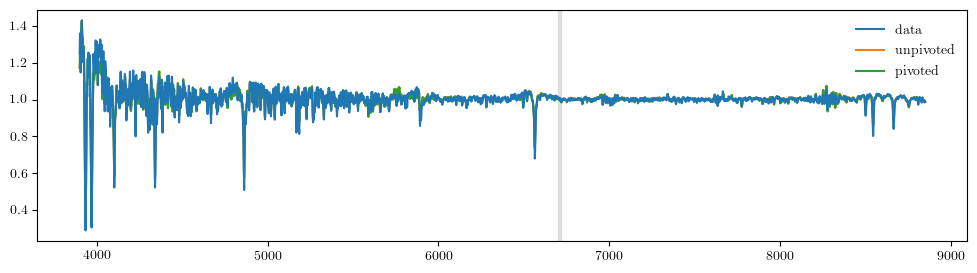

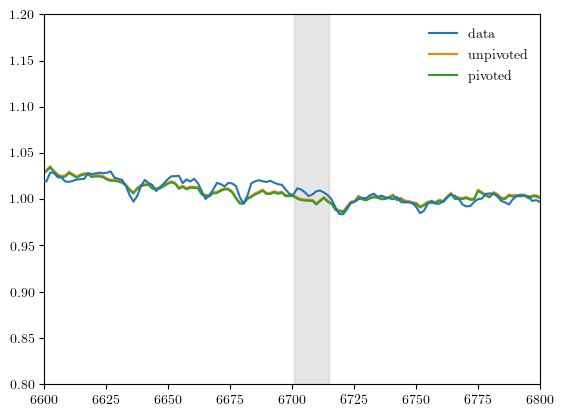

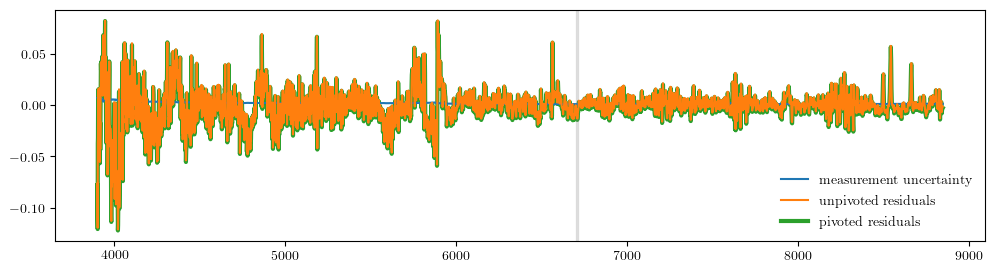

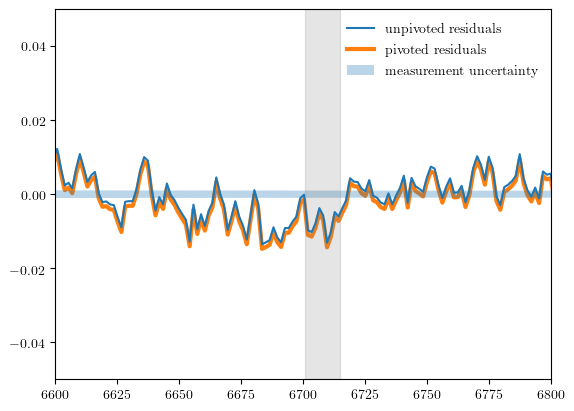

8 allocations: 2.703 KiB)
to calculate weights:   0.007208 seconds (5.42 k allocations: 645.309 KiB)


In [6]:
include("model.jl")

obsid = 251005244

k = 8

Δλ = 7                                                                                                 
li_air = 6707.85
line_mask = li_air - Δλ .< wl_grid .< li_air + Δλ
wlmask = .! line_mask

download_lamost_spectra([obsid])
_, flux, ivar = load_lamost_spectrum(obsid, L=L)
err = Float32.(ivar.^(-1/2))

spectral_dist(f1, s1, f2, s2) = sum(@. (f1-f2)^2/(s1^1 + s2^2))

print("to calculate distances: ")
@time dists = map(1:nstars) do j
    spectral_dist(F[wlmask, j], S[wlmask, j], flux[wlmask], err[wlmask])
end

print("to sort: ")
@time perm = sortperm(dists)
neighbors = perm[2:k+1]

print("to calculate weights: ")
@time w = calculate_weights(F[wlmask, neighbors], flux[wlmask], err[wlmask])
Fmean = mean(F[:, neighbors], dims=2)
Fprime = F[:, neighbors] .- Fmean
wprime = calculate_weights(Fprime[wlmask, :], flux[wlmask] .- Fmean[wlmask], err[wlmask])

figure(figsize=(12, 3))
axvspan(li_air - Δλ, li_air + Δλ, alpha=0.2, color="gray")
plt.plot(wl, flux, label="data", zorder=10)
plt.plot(wl, F[:, neighbors]*w, label="unpivoted")
plt.plot(wl, Fprime*wprime .+ Fmean,  label="pivoted")
legend()

figure()
plt.plot(wl, flux, label="data", zorder=10)
plt.plot(wl, F[:, neighbors]*w, label="unpivoted")
plt.plot(wl, Fprime*wprime .+ Fmean, label="pivoted" )
legend()
xlim(6600, 6800)
ylim(0.8, 1.2)
axvspan(li_air - Δλ, li_air + Δλ, alpha=0.2, color="gray")

figure(figsize=(12, 3))
plt.plot(wl, ivar.^(-1/2), label="measurement uncertainty")
plt.plot(wl, F[:, neighbors]*w .- flux, label="unpivoted residuals")
plt.plot(wl, Fprime*wprime .+ Fmean .- flux, label="pivoted residuals", lw=3, zorder=-1) 
legend()
axvspan(li_air - Δλ, li_air + Δλ, alpha=0.2, color="gray")

figure()
fill_between(wl, -ivar.^(-1/2), ivar.^(-1/2), label="measurement uncertainty", alpha=0.3)
plt.plot(wl, F[:, neighbors]*w .- flux, label="unpivoted residuals")
plt.plot(wl, Fprime*wprime .+ Fmean .- flux, label="pivoted residuals", lw=3, zorder=-1) 
legend()
axvspan(li_air - Δλ, li_air + Δλ, alpha=0.2, color="gray")
xlim(6600, 6800)
ylim(-0.05, 0.05)
;